In [1]:
"""
The purpose of this document is to append IRA rebate logic for 50121 and 50122 (HOMES AND HEER)
so that we can estimate the max rebates available and the relative cost to the consumer. 

"""

'\nThe purpose of this document is to append IRA rebate logic for 50121 and 50122 (HOMES AND HEER)\nso that we can estimate the max rebates available and the relative cost to the consumer. \n\n'

In [111]:
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [3]:
# import files
file = "/Users/kstenger/Documents/Volumes/process_euss_results.csv"
df = pd.read_csv(file)

In [4]:
list(df.columns)

['building_id',
 'sample_weight',
 'ashrae_iecc_climate_zone_2004',
 'census_division',
 'census_region',
 'city',
 'clothes_dryer',
 'clothes_washer',
 'cooking_range',
 'county',
 'county_and_puma',
 'dishwasher',
 'ducts',
 'federal_poverty_level',
 'geometry_attic_type',
 'geometry_building_type_acs',
 'geometry_building_type_height',
 'geometry_building_type_recs',
 'geometry_floor_area_bin',
 'geometry_foundation_type',
 'geometry_wall_type',
 'has_pv',
 'heating_fuel',
 'hvac_cooling_efficiency',
 'hvac_cooling_partial_space_conditioning',
 'hvac_cooling_type',
 'hvac_has_ducts',
 'hvac_has_shared_system',
 'hvac_heating_efficiency',
 'hvac_heating_type',
 'hvac_heating_type_and_fuel',
 'hvac_secondary_heating_efficiency',
 'hvac_secondary_heating_type_and_fuel',
 'hvac_shared_efficiencies',
 'income_recs_2020',
 'infiltration',
 'insulation_ceiling',
 'insulation_foundation_wall',
 'insulation_rim_joist',
 'insulation_roof',
 'insulation_wall',
 'lighting',
 'occupants',
 'puma

In [65]:
df.upgrade_name.unique()

array(['enclosure.basic_upgrade', 'enclosure.enhanced_upgrade',
       'hvac.heat_pump_min_eff_electric_backup',
       'hvac.heat_pump_high_eff_electric_backup',
       'hvac.heat_pump_min_eff_existing_backup',
       'hvac.heat_pump_high_eff_electric_backup + HPWH + enclosure.basic_upgrade',
       'hvac.heat_pump_high_eff_electric_backup + HPWH + enclosure.enhanced_upgrade',
       'water_heater.heat_pump', 'clothes_dryer.electric',
       'clothes_dryer.heat_pump', 'cooking.electric', 'cooking.induction',
       'whole_home.electrification_min_eff',
       'whole_home.electrification_high_eff',
       'whole_home.electrification_high_eff + enclosure.basic_upgrade',
       'whole_home.electrification_high_eff + enclosure.enhanced_upgrade'],
      dtype=object)

# IRA HOMES logic

Rules for IRA HOMES (50121) are energy savings based and apply to different home types differently.

Single Family Dwellings
- 20-35% Energy Savings
    - 0-80 % AMI: $4000/dwelling or 80 % of project costs (whichever is the lesser)
    - 80%+ AMI: $2000/dwelling or 50% of project costs (whichever is the lesser)
- 35%+ Energy Savings
    - 0-80 % AMI: $8000/dwelling or 80% of project costs (whichever is the lesser)
    - 80%+ AMI:$4000/dwelling or 50% of project costs (whichever is the lesser)
    
Multifamily Family Dwellings
- 20-35% Energy Savings
    - 0-80% AMI: 2000 or 80% of project costs (whichever is the lesser)
    - 80%+ AMI: 2000 or 50% of project costs (whichever is the lesser)
- 35%+ Energy Savings
    - 0-80 % AMI: 4000 or 80% of project costs (whichever is the lesser)
    - 80%+ AMI:2000 or 50% of project costs (whichever is the lesser)


In [5]:
# Functions for IRA HOMES

# Prompt
# I have a dataframe named df
# Calculate the max_homes_rebate possible using: 
# df.pct_saving_energy.total_% which is the energy savings
# area_median_income which is AMI. AMI has a bunch of subset categories that need to be lumped together.
# geometry_building_type_acs which is the dwelling type
# The categories df.geometry_building_type_acs for are: 
#['Single-Family Detached', 'Mobile Home', '10 to 19 Unit',
   #'Single-Family Attached', '5 to 9 Unit', '2 Unit', '20 to 49 Unit',
   #'50 or more Unit', '3 or 4 Unit']. 
# The Single-Family categories and Mobile Home should be grouped together 
# The rest should be multifamily

# Please use df.upgrade_cost_usd for project costs to ascertain whichever is lesser

# the application of the rebate rules are: 
# Single Family Dwellings
# - 20-35% Energy Savings
#     - 0-80 % AMI: $4000/dwelling or 80% of project costs (whichever is the lesser)
#     - 80%+ AMI: $2000/dwelling or 50% of project costs (whichever is the lesser)
# - 35%+ Energy Savings
#     - 0-80 % AMI: $8000/dwelling or 80% of project costs (whichever is the lesser)
#     - 80%+ AMI:$4000/dwelling or 50% of project costs (whichever is the lesser)
    
# Multifamily Family Dwellings
# - 20-35% Energy Savings
#     - 0-80 % AMI: $2000/dwelling or 80% of project costs (whichever is the lesser)
#     - 80%+ AMI: $2000/dwelling or 50% of project costs (whichever is the lesser)
# - 35%+ Energy Savings
#     - 0-80 % AMI: $4000/dwelling or 80% of project costs (whichever is the lesser)
#     - 80%+ AMI:$2000/dwelling or 50% of project costs (whichever is the lesser)
    
# Subtract the max_homes_rebate from the original upgrade_cost_usd to create a post_homes_upgrade_cost


In [58]:
#Global Variables

df['building_type_group'] = df['geometry_building_type_acs'].replace({
    'Single-Family Detached': 'Single-Family',
    'Single-Family Attached': 'Single-Family',
    'Mobile Home': 'Single-Family'
})

# Map categorical values of area_median_income to their corresponding ranges
income_ranges = {
    '80-100%': (80, 100),
    '150%+': (150, float('inf')),
    '0-30%': (0, 30),
    '30-60%': (30, 60),
    '100-120%': (100, 120),
    '120-150%': (120, 150),
    '60-80%': (60, 80)
}


# Define rebate amounts based on energy saving ranges and income ranges
rebate_amounts = {
    '0-30%': {'0-20%':0,'20-35%': 4000, '35%+': 8000},
    '30-60%': {'0-20%':0,'20-35%': 4000, '35%+': 8000},
    '60-80%': {'0-20%':0,'20-35%': 4000, '35%+': 8000},
    '80-100%': {'0-20%':0,'20-35%': 2000, '35%+': 4000},
    '150%+': {'0-20%':0,'20-35%': 2000, '35%+': 4000},
    '100-120%': {'0-20%':0,'20-35%': 2000, '35%+': 4000},
    '120-150%': {'0-20%':0,'20-35%': 2000, '35%+': 4000},

}

# Define the project percentages
project_percents = {
    '0-30%': {'20-35%': .8, '35%+': .8},
    '30-60%': {'20-35%': .8, '35%+': .8},
    '60-80%': {'20-35%': .8, '35%+': .8},
    '80-100%': {'20-35%': 0.5, '35%+': 0.5},
    '150%+': {'20-35%': 0.5, '35%+': 0.5},
    '100-120%': {'20-35%': 0.5, '35%+': 0.5},
    '120-150%': {'20-35%': 0.5, '35%+': 0.5},

}

In [79]:
def calculate_project_rebate(row):
    # Retrieve the income range for the row
    income_range = row['income_range']
    
    # Define project percentages for different income ranges within '0-80% AMI'
    project_percentages = {
        '0-30%': 0.8,
        '30-60%': 0.8,
        '60-80%': 0.8
    }
    
    # Determine the project percentage based on the income range
    project_percent = project_percentages.get(income_range, 0.5)
    
    # Calculate the project rebate
    project_rebate = row['upgrade_cost_usd'] * project_percent
    
    # Return the project rebate
    return project_rebate



def homes_rebate(df):

    df['income_range'] = df['area_median_income'].map(income_ranges)
    # Calculate the maximum rebate by demographic
    df.loc[:, 'possible_rebate'] = df.apply(lambda row: rebate_amounts[row['area_median_income']]['35%+'] if row['pct_saving_energy.total_%'] >= 35 else rebate_amounts[row['area_median_income']]['20-35%'] if 20 <= row['pct_saving_energy.total_%'] < 35 else 0, axis=1)

    # Calculated project rebate (upgrade cost * upgrade)
    df['project_rebate'] = df.apply(calculate_project_rebate, axis=1)
    
    df['applicable_homes_rebate'] = df[['possible_rebate', 'project_rebate']].min(axis=1)

    df.loc[:, 'post_homes_upgrade_cost'] = df['upgrade_cost_usd'] - df['applicable_homes_rebate']
    df['post_homes_upgrade_cost'] = df['post_homes_upgrade_cost'].round(2)



    return df


# IRA HEER logic

Rules for IRA HEER (50122) are technology based.
- 0-80% AMI would have 100% project costs covered
- 80-150% AMI would have 50% of project costs covered.

In [78]:
def heer_rebate(df):
    
    # Define the rebate amounts for each upgrade type
    rebate_amounts = {
        'enclosure.basic_upgrade': 1600,
        'enclosure.enhanced_upgrade': 1600,
        'hvac.heat_pump_min_eff_electric_backup': 8000,
        'hvac.heat_pump_high_eff_electric_backup': 8000,
        'hvac.heat_pump_min_eff_existing_backup': 8000,
        'hvac.heat_pump_high_eff_electric_backup + HPWH + enclosure.basic_upgrade': 11350,
        'hvac.heat_pump_high_eff_electric_backup + HPWH + enclosure.enhanced_upgrade': 11350,
        'water_heater.heat_pump': 1750,
        'clothes_dryer.electric': 840,
        'clothes_dryer.heat_pump': 840,
        'cooking.electric': 840,
        'cooking.induction': 840,
        'whole_home.electrification_min_eff': 14000,
        'whole_home.electrification_high_eff': 14000,
        'whole_home.electrification_high_eff + enclosure.basic_upgrade': 14000,
        'whole_home.electrification_high_eff + enclosure.enhanced_upgrade': 14000
    }
    
    # Retrieve the rebate amounts based on the upgrade names in the 'upgrade_name' column
    df['max_heer_rebate'] = df['upgrade_name'].map(rebate_amounts)
    
    # Define project percentages for different income ranges within '0-80% AMI'
    project_percentages = {
        '0-30%': 1,
        '30-60%': 1,
        '60-80%': 1,
        '80-100%': 0.5,
        '100-120%': 0.5,
        '120-150%': 0.5,
        '150%+':0
    }
    
    # Calculate the project percentage for each row based on the income range
    df['heer_project_percent'] = df['area_median_income'].map(project_percentages)
    
    # Calculate the HEER rebate for each row
    df['heer_rebate'] = df['heer_project_percent'] * df['max_heer_rebate']
    
    return df


# Sandbox

In [80]:
df_revised = homes_rebate(df)
df_revised = heer_rebate(df_revised)

In [81]:
list(df_revised.columns)

['building_id',
 'sample_weight',
 'ashrae_iecc_climate_zone_2004',
 'census_division',
 'census_region',
 'city',
 'clothes_dryer',
 'clothes_washer',
 'cooking_range',
 'county',
 'county_and_puma',
 'dishwasher',
 'ducts',
 'federal_poverty_level',
 'geometry_attic_type',
 'geometry_building_type_acs',
 'geometry_building_type_height',
 'geometry_building_type_recs',
 'geometry_floor_area_bin',
 'geometry_foundation_type',
 'geometry_wall_type',
 'has_pv',
 'heating_fuel',
 'hvac_cooling_efficiency',
 'hvac_cooling_partial_space_conditioning',
 'hvac_cooling_type',
 'hvac_has_ducts',
 'hvac_has_shared_system',
 'hvac_heating_efficiency',
 'hvac_heating_type',
 'hvac_heating_type_and_fuel',
 'hvac_secondary_heating_efficiency',
 'hvac_secondary_heating_type_and_fuel',
 'hvac_shared_efficiencies',
 'income_recs_2020',
 'infiltration',
 'insulation_ceiling',
 'insulation_foundation_wall',
 'insulation_rim_joist',
 'insulation_roof',
 'insulation_wall',
 'lighting',
 'occupants',
 'puma

## Clean up dataset and columns

In [83]:
df['post_heer_upgrade_cost'] = df['upgrade_cost_usd'] - df['heer_rebate']

# Remove these columns for data cleaning
cols_to_remove = ['income_range', 'possible_rebate', 'project_rebate',
                 'max_heer_rebate','heer_project_percent',]  # Example list of columns to remove

# Remove the specified columns
df_revised = df_revised.drop(cols_to_remove, axis=1)



In [117]:
df_revised.to_csv('process_euss_results_ira_rebates.csv')

## Quality check

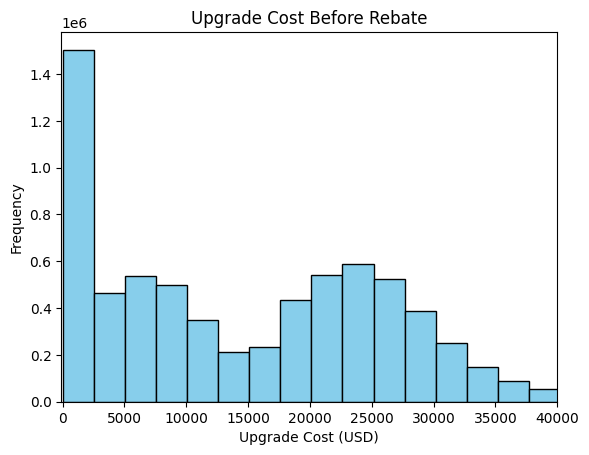

In [109]:
plt.hist(df_revised.upgrade_cost_usd, bins=500, color='skyblue', edgecolor='black')
plt.xlim(-100, 40000)
plt.title('Upgrade Cost Before Rebate')
plt.xlabel('Upgrade Cost (USD)')
plt.ylabel('Frequency')
plt.show()

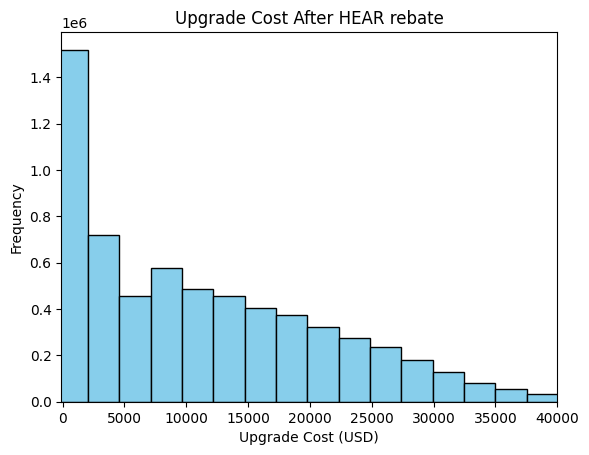

In [110]:
plt.hist(df_revised.post_heer_upgrade_cost, bins=500, color='skyblue', edgecolor='black')
plt.xlim(-100, 40000)
plt.title('Upgrade Cost After HEAR rebate')
plt.xlabel('Upgrade Cost (USD)')
plt.ylabel('Frequency')
plt.show()

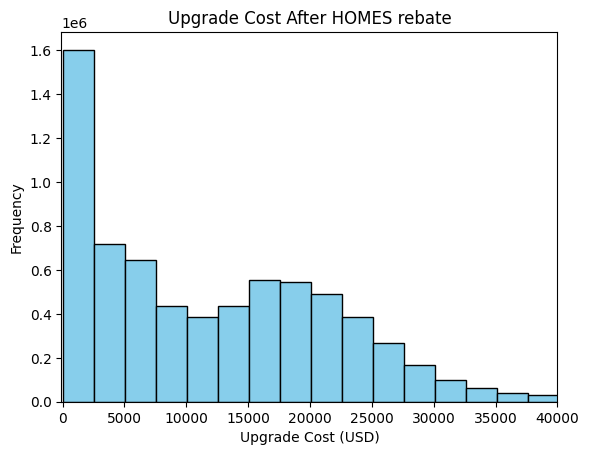

In [107]:
plt.hist(df_revised.post_homes_upgrade_cost, bins=500, color='skyblue', edgecolor='black')
plt.xlim(-100, 40000)
plt.title('Upgrade Cost After HOMES rebate')
plt.xlabel('Upgrade Cost (USD)')
plt.ylabel('Frequency')
plt.show()

In [3]:
# # Get unique upgrade names
# upgrade_names = df_revised['upgrade_name'].unique()

# # Create a figure for each upgrade name
# figures = []
# for upgrade_name in upgrade_names:
#     # Filter data for the current upgrade name
#     data = df_revised[df_revised['upgrade_name'] == upgrade_name]['upgrade_cost_usd']
    
#     # Create the histogram plot
#     fig = go.Figure(data=[go.Histogram(x=data)])
    
#     # Update layout
#     fig.update_layout(
#         title=f'Histogram for {upgrade_name}',
#         xaxis_title='Upgrade Cost (USD)',
#         yaxis_title='Frequency',
#         xaxis=dict(range=[0, 80000])
#     )
    
#     file_path = "/Users/kstenger/Documents/c. IRA_Estimation/i. SCEP dashboard/original cost/"
#     fig.write_image(file_path+upgrade_name+"_original_cost.png")
#     # Append the figure to the list
#     figures.append(fig)

# # Show the figures
# for fig in figures:
    
#     fig.show()


In [1]:
# # Get unique upgrade names
# upgrade_names = df_revised['upgrade_name'].unique()

# # Create a figure for each upgrade name
# figures = []
# for upgrade_name in upgrade_names:
#     # Filter data for the current upgrade name
#     data = df_revised[df_revised['upgrade_name'] == upgrade_name]['post_homes_upgrade_cost']
    
#     # Create the histogram plot
#     fig = go.Figure(data=[go.Histogram(x=data)])
    
#     # Update layout
#     fig.update_layout(
#         title=f'Histogram for {upgrade_name}',
#         xaxis_title='Upgrade Cost (USD)',
#         yaxis_title='Frequency',
#         xaxis=dict(range=[0, 80000])
#     )
    
#     file_path = "/Users/kstenger/Documents/c. IRA_Estimation/i. SCEP dashboard/homes cost/"
#     fig.write_image(file_path+upgrade_name+"_homes_cost.png")
#     # Append the figure to the list
#     figures.append(fig)

# # Show the figures
# for fig in figures:
    
#     fig.show()

In [2]:
# # Get unique upgrade names
# upgrade_names = df_revised['upgrade_name'].unique()

# # Create a figure for each upgrade name
# figures = []
# for upgrade_name in upgrade_names:
#     # Filter data for the current upgrade name
#     data = df_revised[df_revised['upgrade_name'] == upgrade_name]['post_heer_upgrade_cost']
    
#     # Create the histogram plot
#     fig = go.Figure(data=[go.Histogram(x=data)])
    
#     # Update layout
#     fig.update_layout(
#         title=f'Histogram for {upgrade_name}',
#         xaxis_title='Upgrade Cost (USD)',
#         yaxis_title='Frequency',
#         xaxis=dict(range=[0, 80000])
#     )
    
#     file_path = "/Users/kstenger/Documents/c. IRA_Estimation/i. SCEP dashboard/hear cost/"
#     fig.write_image(file_path+upgrade_name+"_hear_cost.png")
#     # Append the figure to the list
#     figures.append(fig)

# # Show the figures
# for fig in figures:
    
#     fig.show()